<a href="https://colab.research.google.com/github/shubhamtheds/COCO-ML-DL-Classifier/blob/main/coco_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import zipfile
import shutil
import cv2
import numpy as np
from pycocotools.coco import COCO
import random
import hashlib
import os
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
import joblib

In [ ]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
class CocoDatasetDownloader:
    def __init__(self, object_classes, num_images_per_class, min_object_size, image_size):
        self.dataset_url = 'http://images.cocodataset.org/zips/train2017.zip'
        self.annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
        self.dataset_folder = '/content/coco_dataset'
        self.resized_folder = '/content/coco_resized'
        self.annotations_folder = '/content'
        self.object_classes = object_classes
        self.num_images_per_class = num_images_per_class
        self.min_object_size = min_object_size
        self.image_size = image_size
    
    def download_dataset(self):
        # Downloading COCO dataset
        if not os.path.exists(self.dataset_folder):
            print('Downloading COCO dataset...')
            response = requests.get(self.dataset_url, stream=True)
            with open('train2017.zip', 'wb') as f:
                shutil.copyfileobj(response.raw, f)
            with zipfile.ZipFile('train2017.zip', 'r') as zip_ref:
                zip_ref.extractall(self.dataset_folder)
            os.remove('train2017.zip')

        # Downloading COCO annotations
        if not os.path.exists(os.path.join(self.annotations_folder, 'annotations')):
            print('Downloading COCO annotations...')
            response = requests.get(self.annotations_url, stream=True)
            with open('annotations_trainval2017.zip', 'wb') as f:
                shutil.copyfileobj(response.raw, f)
            with zipfile.ZipFile('annotations_trainval2017.zip', 'r') as zip_ref:
                zip_ref.extractall(self.annotations_folder)
            os.remove('annotations_trainval2017.zip')

    def process_dataset(self):
        coco = COCO(os.path.join(self.annotations_folder, 'annotations', 'instances_train2017.json'))

        categories = coco.loadCats(coco.getCatIds())
        category_map = {category['id']: category['name'] for category in categories}

        # Initializing dictionaries to store images and counts per class
        class_images = {object_class: [] for object_class in self.object_classes}
        class_counts = {object_class: 0 for object_class in self.object_classes}

        for image_id in coco.getImgIds():
            image = coco.loadImgs(image_id)[0]
            annotations = coco.loadAnns(coco.getAnnIds(imgIds=image['id']))

            # Check if image contains desired object
            object_class_present = False
            for annotation in annotations:
                category_id = annotation['category_id']
                if category_map[category_id] in self.object_classes:
                    object_class_present = True
                    break

            if not object_class_present:
                continue

            image_path = os.path.join(self.dataset_folder, 'train2017', image['file_name'])
            img = cv2.imread(image_path)

            for annotation in annotations:
                category_id = annotation['category_id']
                object_class = category_map[category_id]

                if object_class not in self.object_classes:
                    continue

                # Checking if size of object is big enough
                bbox = annotation['bbox']
                object_size = max(bbox[2], bbox[3])
                if object_size < self.min_object_size:
                    continue

                # Check if we have already collected enough images for this class
                if class_counts[object_class] >= self.num_images_per_class:
                    continue

                # Croping and resizing image
                x, y, w, h = [int(val) for val in bbox]
                x1, y1, x2, y2 = x, y, x + w, y + h
                crop_size = max(w, h)
                center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                x1 = center_x - crop_size // 2
                y1 = center_y - crop_size // 2
                x2 = x1 + crop_size
                y2 = y1 + crop_size
                crop = img[y1:y2, x1:x2]

                if crop.size == 0:
                    continue
                resized_crop = cv2.resize(crop, (self.image_size, self.image_size))

                # Compute hash of image and check if it has already been saved
                with open(image_path, 'rb') as f:
                    image_data = f.read()
                image_hash = hashlib.sha256(image_data).hexdigest()
                if image_hash not in class_images[object_class]:
                    # Saving image to new path
                    folder_path = os.path.join(self.resized_folder, object_class)
                    if not os.path.exists(folder_path):
                        os.makedirs(folder_path)
                    image_path = os.path.join(folder_path, f'{image_hash}.jpg')
                    cv2.imwrite(image_path, resized_crop)
    
                    class_images[object_class].append(image_hash)
                    class_counts[object_class] += 1
    
                # exit loop after collecting images
                if class_counts[object_class] >= self.num_images_per_class:
                    break

In [3]:
object_classes = ['traffic light', 'clock', 'cup', 'airplane', 'bus', 'umbrella', 'bowl']
image_size = 32
num_images_per_class = 5000
min_object_size = 16

downloader = CocoDatasetDownloader(object_classes, num_images_per_class, min_object_size, image_size)
downloader.download_dataset()
downloader.process_dataset()

loading annotations into memory...
Done (t=16.78s)
creating index...
index created!


## CLASSICAL ML APPROACH

In [4]:
class ImageClassifier:
    def __init__(self, dataset_folder, object_classes, test_size=0.2, random_state=42, stratify=None):
        self.dataset_folder = dataset_folder
        self.object_classes = object_classes
        self.test_size = test_size
        self.random_state = random_state
        self.stratify = stratify
    
    def load_data(self):
        X = []
        y = []

        for object_class in self.object_classes:
            folder_path = os.path.join(self.dataset_folder, object_class)
            image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
            for image_path in image_paths:
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
                    image = cv2.resize(image, (32, 32))
                    X.append(image)
                    y.append(object_class)

        X = np.array(X)
        y = np.array(y)

        # Spliting data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=self.stratify)

        # Reshaping images to 2D arrays
        nsamples, nx, ny, nrgb = X_train.shape
        X_train = X_train.reshape((nsamples, nx * ny * nrgb))
        nsamples, nx, ny, nrgb = X_val.shape
        X_val = X_val.reshape((nsamples, nx * ny * nrgb))

        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
    
    def train_and_evaluate(self, classifiers):
        for clf_dict in classifiers:
            clf_name = clf_dict['name']
            clf = clf_dict['clf'](**clf_dict['params'])
            clf.fit(self.X_train, self.y_train)
            y_val_pred = clf.predict(self.X_val)
            print(f"{clf_name} Classification Report:")
            print(classification_report(self.y_val, y_val_pred))

In [5]:
dataset_folder = '/content/coco_resized'
object_classes = ['traffic light', 'clock', 'cup', 'airplane', 'bus', 'umbrella', 'bowl']
classifiers = [{'name': 'Random Forest', 'clf': RandomForestClassifier, 'params': {'n_estimators': 200}}]

ic = ImageClassifier(dataset_folder, object_classes)
ic.load_data()
ic.train_and_evaluate(classifiers)

Random Forest Classification Report:
               precision    recall  f1-score   support

     airplane       0.62      0.62      0.62       917
         bowl       0.44      0.45      0.45       995
          bus       0.46      0.57      0.51       963
        clock       0.68      0.61      0.65      1013
          cup       0.49      0.43      0.46      1026
traffic light       0.63      0.75      0.69      1012
     umbrella       0.51      0.40      0.45      1014

     accuracy                           0.55      6940
    macro avg       0.55      0.55      0.55      6940
 weighted avg       0.55      0.55      0.54      6940



## DEEP LEARNING APPROACH WITH KERAS API


In [6]:
class ObjectClassifier:
    def __init__(self, dataset_folder, object_classes):
      # Initializing the ObjectClassifier class with the dataset folder and object classes
        self.dataset_folder = dataset_folder
        self.object_classes = object_classes
        self.num_classes = len(self.object_classes)
        self.label_map = {object_class: i for i, object_class in enumerate(self.object_classes)}

    def load_and_preprocess_data(self):
      # Loading and preprocessing the data
        X = []
        y = []

        for object_class in self.object_classes:
            folder_path = os.path.join(self.dataset_folder, object_class)
            image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
            for image_path in image_paths:
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (32, 32))
                    X.append(image)
                    y.append(object_class)

        X = np.array(X)
        y = np.array(y)

        # Splitting the data into training and validation sets and normalizing the pixel values
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        X_train = X_train / 255.0
        X_val = X_val / 255.0

        # Converting the labels to numerical values and one-hot encoding them
        y_train_num = np.array([self.label_map[label] for label in y_train])
        y_val_num = np.array([self.label_map[label] for label in y_val])

        y_train_onehot = to_categorical(y_train_num)
        y_val_onehot = to_categorical(y_val_num)

        return X_train, X_val, y_train_onehot, y_val_onehot, y_val_num

    def create_model(self):
        # Creating a convolutional neural network model
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        return model  

    def train_and_evaluate(self, num_epochs=100, batch_size=64, patience=100):
      # Training and evaluating the model
        X_train, X_val, y_train_onehot, y_val_onehot, y_val_num = self.load_and_preprocess_data()
        model = self.create_model()

        early_stop = EarlyStopping(monitor='val_loss', mode='max', patience=patience)

        history = model.fit(X_train, y_train_onehot, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot), callbacks=[early_stop])

        y_pred_onehot = model.predict(X_val)
        y_pred_num = np.argmax(y_pred_onehot, axis=1)

        # Generating the classification report and printing it
        report = classification_report(y_val_num, y_pred_num, target_names=self.object_classes)
        print('\nClassification Report:')
        print(report)

        accuracy = accuracy_score(y_val_num, y_pred_num)

        # Ploting average of F1 score, accuracy, precision, and recall
        report_dict = classification_report(y_val_num, y_pred_num, target_names=self.object_classes, output_dict=True)
        averages = ['macro avg', 'weighted avg']
        plot_data = {}

        for avg in averages:
            plot_data[avg] = [
                report_dict[avg]['precision'],
                report_dict[avg]['recall'],
                report_dict[avg]['f1-score'],
                accuracy
            ]

        plot_df = pd.DataFrame.from_dict(plot_data, orient='index', columns=['precision', 'recall', 'F1-score', 'accuracy'])
        sns.set(style="whitegrid")
        sns.set_palette("pastel")
        ax = sns.barplot(data=plot_df,  palette=sns.color_palette("pastel"), linewidth=1.5)
        ax.set(ylabel='Metrics', xlabel='Average', title='Average of F1 score, accuracy, precision and recall')
        plt.show()

Epoch 1/100
434/434 [==============================] - 22s 16ms/step - loss: 1.6468 - accuracy: 0.4464 - val_loss: 1.1736 - val_accuracy: 0.5821
Epoch 2/100
434/434 [==============================] - 6s 13ms/step - loss: 1.0889 - accuracy: 0.6176 - val_loss: 0.9490 - val_accuracy: 0.6682
Epoch 3/100
434/434 [==============================] - 6s 13ms/step - loss: 0.9301 - accuracy: 0.6728 - val_loss: 0.8375 - val_accuracy: 0.6976
Epoch 4/100
434/434 [==============================] - 6s 14ms/step - loss: 0.8432 - accuracy: 0.7055 - val_loss: 0.8033 - val_accuracy: 0.7171
Epoch 5/100
434/434 [==============================] - 6s 13ms/step - loss: 0.7794 - accuracy: 0.7286 - val_loss: 0.7691 - val_accuracy: 0.7269
Epoch 6/100
434/434 [==============================] - 6s 14ms/step - loss: 0.7445 - accuracy: 0.7398 - val_loss: 0.7376 - val_accuracy: 0.7432
Epoch 7/100
434/434 [==============================] - 6s 13ms/step - loss: 0.6823 - accuracy: 0.7636 - val_loss: 0.6692 - val_accuracy

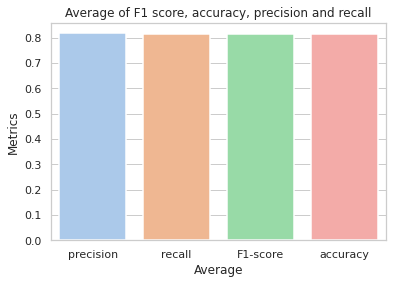

In [7]:
object_classes = ['traffic light', 'clock', 'cup', 'airplane', 'bus', 'umbrella', 'bowl']
dataset_folder = '/content/coco_resized'

classifier = ObjectClassifier(dataset_folder, object_classes)
classifier.train_and_evaluate()